In [1]:
import warnings
from collections import Counter
import IPython
from IPython.core.display import display
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from collections import defaultdict

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *
from tqdm import tqdm

MODELS_PATH = './models'
dataset = 'german'
seed = 1
np.random.seed(seed)

# A. Load data, preprocess, and calculate accuracy

In [2]:
X, y, le = read_data(dataset)

In [3]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features=[]
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
#keep train alone and test alone for create excel file in code
#further in the code
X_train_data = X_train
X_test_data = X_test
y_train_data = y_train
y_test_data= y_test
# will used it after/before training

#print(X_train_data[0])

#X_train_data

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

(500, 24)
(500, 24)
(500,)
(500,)
model score: 0.762


# B. Plot confidence scores for all the data

In [4]:
#putted in comment the line below, so X_train will not be the whole data
#X_train, y_train = X, y
#clf.fit(X_train, y_train)
#the comment above was allready calc one cell before
y_prob = rf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores
print("y_conf_train\n")
#print(y_conf_train)

y_conf_train



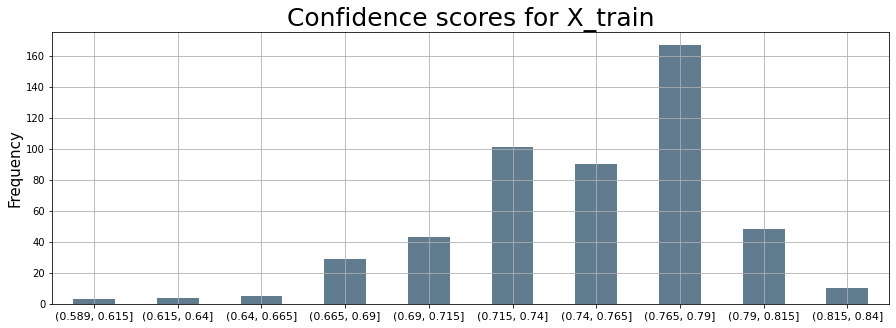

In [5]:
0
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

# C. Select C as the middle of top intervals

In [6]:
# Create bucket (intervals) from generated data
top_c = 10
conf_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values
#print(idxs[0])
akaka=idxs.contains(0.6)
print(freqs)
freqsSum = freqs.sum()
print(freqsSum)


# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]
top_c_lst = sorted(round(x, 4) for x in top_c_lst)

[  3   4   5  29  43 101  90 167  48  10]
500


In [7]:
top_c_lst

[0.602, 0.6275, 0.6525, 0.6775, 0.7025, 0.7275, 0.7525, 0.7775, 0.8025, 0.8275]

# D. Train one CTGAN with middle of intervals (10 Confidence levels)

In [8]:
"""
# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all
X_train_pd = pd.DataFrame(X_train)



# train CTGAN
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
#confidence_level = c
gen_lr = 2e-5
loss = 'log'

#now ctgan synthesizer gets conf levels as input
rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss,
                            confidence_levels=top_c_lst
                            )
#print(rf_ctgan.confidence_levels)

print(f"Training CTGAN for c list = {top_c_lst} ...")
#removed conf level from fit input arguements
allconf_levels_hist = rf_ctgan.fit(train_data=z,
                                   epochs=epochs,
                                   gen_lr=gen_lr,
                                   verbose=False
                                  )

#print("\nhistory of all confidence levels:\n")
#print(allconf_levels_hist)
#print("\n\n")
# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
# plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
# print()

#allsamplesInv = 0
#allDataFrames = []
#allgeninv= 0
alldataframescoverage =[]
alldataframesprecision =[]
freqsCounter = 0
#add here conf loop, send each conf to samples as input each loop
for c in top_c_lst:
    print("\tGenerate samples to same dist...")
    # Generate samples to same dist
    samples = 100000
    #samples = 200000
    gen_data,gen_fakeacts = rf_ctgan.sample(samples,c)
    y_prob = rf.predict_proba(gen_data)
    print(y_prob)
    y_conf_gen = y_prob[:, 0]  # confidence scores
    #print(y_conf_gen)
    #print(y_conf_train)

    #train_bucktes_gen = pd.value_counts(y_conf_gen, bins=10, sort=False)
    #print(train_bucktes_gen)
    # ans is the indices of gen_data to make the same dist
    ans,train_ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]

    #take only relevant sample from train
    relevant_train_data = X_train_pd.iloc[train_ans]
    relevant_y_conf_train = y_conf_train[train_ans]



    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
    gen_data_inv = pd.DataFrame(gen_data_inv)

    #calc all inv
    #freqs[freqsCounter] probably in our the gen size data train
    # in the interval bin that c in it
    #allgeninv = allgeninv + freqs[freqsCounter]
    #calc end

    # y_conf_gen_same_dist, gen_data_inv what we want
    # results
    # E. Calculate coverage for each similarity and conf diff thresholds

    #sum all geninvsamples
    #allsamplesInv =allsamplesInv + gen_data_inv.size()

    print("gen_data")
    print(gen_data_inv.shape)
    print("relevant_X_train")
    print(relevant_train_data.shape)
    print("y_conf_gen")
    print(y_conf_gen_same_dist.shape)
    print("relevant_y_conf_train")
    print(relevant_y_conf_train.shape)


    print(f"\tWorking on results...")
    results,coverage, precision = table(gen_data_inv, relevant_train_data, y_conf_gen_same_dist, relevant_y_conf_train)

    print("datagen inv size:")
    print(gen_data_inv.size)
    print("\n")
    print("current bin size:")
    print(freqs[freqsCounter])
    print("\n")

    #keep all data frames
    alldataframescoverage.append([coverage,freqs[freqsCounter]])
    alldataframesprecision.append([precision,freqs[freqsCounter]])
   # allDataFrames.append(results)

    print(f"\tResults for confidence level = {c}")
    display(results)
    freqsCounter=freqsCounter+1




#print("allgen in size")
#print(allgeninv)
#print("\n")
print("all bins size")
print(freqsSum)
print("\n")

print("calculate weighted average results\n")
a= alldataframescoverage[0][0] *0
#display(a)
for index in range(len(alldataframescoverage)):
    #func = lambda s1, s2: s1 + s2*alldataframes[index][1]
    a= a+ alldataframescoverage[index][0]*alldataframescoverage[index][1]
a = a/freqsSum
#display weighted averaged coverage
display(a)


b= alldataframesprecision[0][0] *0
#display(b)
for index in range(len(alldataframesprecision)):
    #func = lambda s1, s2: s1 + s2*alldataframes[index][1]
    b= b+ alldataframesprecision[index][0]*alldataframesprecision[index][1]
b = b/freqsSum
#display weighted averaged precision
display(b)

a = a.astype(str)
b = b.astype(str)

result_weighted_Average = a+" | "+b

print("result_weighted_Average:\n")
display(result_weighted_Average)

"""

'\n# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)\n# X_train = X_all\nX_train_pd = pd.DataFrame(X_train)\n\n\n\n# train CTGAN\nz_features = get_noise_features(X_train, categorical_features)\nz_rows = int(0.25 * X_train.shape[0])\nz = gen_random_noise(shape=(z_rows, z_features))\n\nbatch_size = 50\nepochs = 50\n#confidence_level = c\ngen_lr = 2e-5\nloss = \'log\'\n\n#now ctgan synthesizer gets conf levels as input\nrf_ctgan = CTGANSynthesizer(batch_size=batch_size,\n                            blackbox_model=rf,\n                            preprocessing_pipeline=preprocessor,\n                            bb_loss=loss,\n                            confidence_levels=top_c_lst\n                            )\n#print(rf_ctgan.confidence_levels)\n\nprint(f"Training CTGAN for c list = {top_c_lst} ...")\n#removed conf level from fit input arguements\nallconf_levels_hist = rf_ctgan.fit(train_data=z,\n                                   epochs=epochs,\n                        

In [9]:

import xlsxwriter
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

#create excel file
workbook = xlsxwriter.Workbook('German_confidences.xlsx')




#keeps train and test seperatly
#clf.fit(X_train_data, y_train_data)
#y_prob_train_data = rf.predict_proba(X_train_data)
y_conf_train_data = y_conf_train  # confidence scores
print("y_conf_train_data\n")

#clf.fit(X_test_data, y_test_data)
y_prob_test_data = rf.predict_proba(X_test_data)
y_conf_test_data = y_prob_test_data[:, 0]  # confidence scores
print("y_conf_test_data\n")
#print(y_conf_train)
#keeped



# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all
X_train_pd = pd.DataFrame(X_train)



# train CTGAN
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
#confidence_level = c
gen_lr = 2e-5
loss = 'log'

#now ctgan synthesizer gets conf levels as input
rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss,
                            confidence_levels=top_c_lst
                            )
#print(rf_ctgan.confidence_levels)

print(f"Training CTGAN for c list = {top_c_lst} ...")
#removed conf level from fit input arguements
allconf_levels_hist = rf_ctgan.fit(train_data=z,
                                   epochs=epochs,
                                   gen_lr=gen_lr,
                                   verbose=False
                                  )

#print("\nhistory of all confidence levels:\n")
#print(allconf_levels_hist)
#print("\n\n")
# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
# plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
# print()

#allsamplesInv = 0
#allDataFrames = []
#allgeninv= 0
#alldataframescoverage =[]
#alldataframesprecision =[]
freqsCounter = 0
#add here conf loop, send each conf to samples as input each loop

#to delete
#c= top_c_lst[0]
#top_c_lst = [c]
#delete above
for c in top_c_lst:
    print("\tGenerate samples to same dist...")
    # Generate samples to same dist
    samples = 100000
    gen_data,gen_fakeacts = rf_ctgan.sample(samples,c)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores
    
    print("gen data\n")
    print(gen_data)

    # ans is the indices of gen_data to make the same dist
    ans,train_ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]

    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
    #gen_data_inv = pd.DataFrame(gen_data_inv)

    #find kmean to geninv ndarray
    kmeans = KMeans(n_clusters=1).fit(gen_data_inv)
    gen_data_inv_centroide = kmeans.cluster_centers_

    #create new worksheet, excel for bin Contains Conf c
    name ="bin Contains Conf "+str(c)
    worksheet = workbook.add_worksheet(name)

    #create columns name of excel worksheet
    worksheet.write('A1', 'TR/TS_index')
    worksheet.write('B1', 'train/test')
    worksheet.write('C1', 'cosin_similarity')

    #fill the current worksheet excel
    row =1
    col = 0
    #isTrain= True
    #j=0
    # Iterate over the data and write it out row by row.
    #train_counter = 0
    #print(x_train_data[0])
    #print(x_train_data[0].shape)
    #print(gen_data_inv_centroide)
    #print(gen_data_inv_centroide.shape)
    for sample_idx, sample_conf in enumerate (y_conf_train_data):
        #if the conf of data is in the current interval
        #so we want to add it to the excel bin conf
        if(idxs.contains(sample_conf)[freqsCounter]):
            #print("train entered to excel\n")
            #down i reshaped to make the train data[freqcount]
            #to be in 2D as needed(was 1D) and 1 -1 to make it (1,24)
            csm = cosine_similarity(gen_data_inv_centroide, X_train_data[sample_idx].reshape(1,-1)).squeeze()
            #print(csm)
            #print(sample_idx)
            #print(row)
            #print(col)
            worksheet.write(row, col, sample_idx)
            worksheet.write(row, col + 1, 'train')
            worksheet.write(row, col + 2, csm)
           # isTrain = !isTrain
            row += 1
            #j+=1
            #train_counter+=1



    col = 0
    #isTrain= True
    #j=0
    # Iterate over the data and write it out row by row.
    #test_counter = 0
    #print(y_conf_train_data)
    #print(y_conf_test_data)

    for sample_idx, sample_conf in enumerate (y_conf_test_data):
        #print("in test loop\n")
        #if the conf of data is in the current interval bin
        #so we want to add it to the excel bin conf
        if(idxs.contains(sample_conf)[freqsCounter]):
            #print("test entered to excel\n")
            csm = cosine_similarity(gen_data_inv_centroide, X_test_data[sample_idx].reshape(1,-1)).squeeze()
            worksheet.write(row, col, sample_idx)
            worksheet.write(row, col + 1, 'test')
            worksheet.write(row, col + 2, csm)
           # isTrain = !isTrain
            row += 1
            #j+=1
            #test_counter+=1



    freqsCounter=freqsCounter+1

workbook.close()

    #calcute and create excel



y_conf_train_data

y_conf_test_data



KeyboardInterrupt: 